In [1]:
# Import essential libraries
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
from utils.graph_utils import *

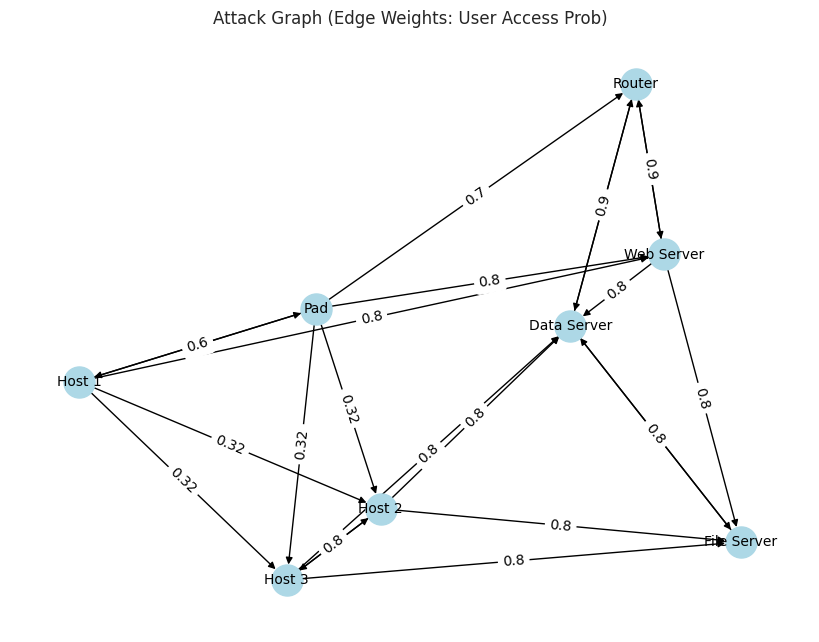

In [2]:
# --- Step 1: Create directed attack graph ---
G_original = nx.DiGraph()

G_original.add_nodes_from(["Data Server", "Pad", "Web Server", "Host 1", "Host 2", "Host 3", "File Server",
                              "Router" # ADDED: New central node
                           ])

# --- Step 2: Update node attributes (priority + state) ---
node_attributes = {
    "Data Server": {"state": 0, "priority": 2},
    "Pad": {"state": 0, "priority": 1},
    "Web Server": {"state": 0, "priority": 1},
    "Host 1": {"state": 0, "priority": 1},
    "Host 2": {"state": 0, "priority": 0},
    "Host 3": {"state": 0, "priority": 0},
    "File Server": {"state": 0, "priority": 0},
    "Router": {"state": 0, "priority": 2} # ADDED: High priority for a central networking device
}
nx.set_node_attributes(G_original, node_attributes)
# --- Step 3: Update edges with weights (user/root access probabilities) ---
edges = [
    # Original Edges (Kept for continuity)
    ("Pad", "Host 1", {"user": 0.6, "root": 0.48}),
    ("Pad", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Pad", "Host 3", {"user": 0.32, "root": 0.32}),
    ("Pad", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Pad", {"user": 0.6, "root": 0.6}),
    ("Host 1", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Host 1", "Host 3", {"user": 0.32, "root": 0.32}),
    ("Host 2", "Host 3", {"user": 0.8, "root": 0.8}),
    ("Host 2", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 2", "Data Server", {"user": 0.8, "root": 0.6}),
    ("Host 3", "Host 2", {"user": 0.8, "root": 0.8}),
    ("Host 3", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 3", "Data Server", {"user": 0.8, "root": 0.6}),
    ("Web Server", "File Server", {"user": 0.8, "root": 0.04}),
    ("Web Server", "Data Server", {"user": 0.8, "root": 0.04}),
    ("File Server", "Data Server", {"user": 0.8, "root": 0.04}),

    # NEW EDGES (To improve realism)

    # Data Server to File Server (Back-path for logging/backup)
    ("Data Server", "File Server", {"user": 0.6, "root": 0.02}),

    # Core Server to Router and vice-versa (All major traffic goes through the router)
    ("Router", "Web Server", {"user": 0.9, "root": 0.9}), # High access probability
    ("Web Server", "Router", {"user": 0.9, "root": 0.9}),
    ("Router", "Data Server", {"user": 0.9, "root": 0.1}), # High user access, but very restricted root access to data server
    ("Data Server", "Router", {"user": 0.9, "root": 0.9}),

    # Pad/Workstation to Router (External access point)
    ("Pad", "Router", {"user": 0.7, "root": 0.5}),
]


G_original.add_edges_from(edges)
node_order = list(G_original.nodes())
node_features = torch.tensor([[G_original.nodes[n]['state'], G_original.nodes[n]['priority']] for n in node_order], dtype=torch.float32)
edge_features = torch.tensor([[d['user'], d['root']] for u, v, d in G_original.edges(data=True)], dtype=torch.float32)
g_dgl = dgl.from_networkx(G_original)
g_dgl.ndata['h'] = node_features
g_dgl.edata['h'] = edge_features

# --- Visualize the graph ---
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_original)
nx.draw(G_original, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
edge_labels = nx.get_edge_attributes(G_original, 'user')
nx.draw_networkx_edge_labels(G_original, pos, edge_labels=edge_labels)
plt.title("Attack Graph (Edge Weights: User Access Prob)")
plt.show()

In [3]:
# --- 1. Chuyển đổi đồ thị sang DGL và trích xuất đặc trưng ---

# DGL yêu cầu các nút phải có ID là số nguyên. Tạo một danh sách các nút theo thứ tự.
node_order = list(G_original.nodes())

# Trích xuất đặc trưng của các nút theo đúng thứ tự và chuyển thành Tensor.
# 2 đặc trưng: 'state' và 'priority'.
node_features_list = [G_original.nodes[n] for n in node_order]
node_features = torch.tensor([[n['state'], n['priority']] for n in node_features_list], dtype=torch.float32)

# Trích xuất đặc trưng của các cạnh và chuyển thành Tensor.
# 2 đặc trưng: 'user' và 'root'.
edge_features_list = [d for u, v, d in G_original.edges(data=True)]
edge_features = torch.tensor([[e['user'], e['root']] for e in edge_features_list], dtype=torch.float32)

# Chuyển đổi đồ thị networkx sang DGL.
# node_attrs và edge_attrs chỉ định tên các thuộc tính cần sao chép.
g_dgl = dgl.from_networkx(G_original, node_attrs=['state', 'priority'], edge_attrs=['user', 'root'])

# Gán các Tensor đặc trưng đã tạo vào đồ thị DGL.
# Dùng tên 'h' để thống nhất với class đã viết.
g_dgl.ndata['h'] = node_features
g_dgl.edata['h'] = edge_features

print("--- Thông tin đồ thị DGL ---")
print(g_dgl)
print("\nĐặc trưng các nút (Node Features) shape:", g_dgl.ndata['h'].shape)
print("Đặc trưng các cạnh (Edge Features) shape:", g_dgl.edata['h'].shape)


--- Thông tin đồ thị DGL ---
Graph(num_nodes=8, num_edges=23,
      ndata_schemes={'state': Scheme(shape=(), dtype=torch.int64), 'priority': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={'user': Scheme(shape=(), dtype=torch.float32), 'root': Scheme(shape=(), dtype=torch.float32), 'h': Scheme(shape=(2,), dtype=torch.float32)})

Đặc trưng các nút (Node Features) shape: torch.Size([8, 2])
Đặc trưng các cạnh (Edge Features) shape: torch.Size([23, 2])


In [4]:
# --- 2. Khởi tạo và chạy mô hình ---

# Xác định các tham số cho mô hình GNN
NDIM_IN = g_dgl.ndata['h'].shape[1]  # Kích thước đặc trưng nút đầu vào ( = 2)
EDIM = g_dgl.edata['h'].shape[1]    # Kích thước đặc trưng cạnh ( = 2)
N_HIDDEN = 16                      # Kích thước của tầng ẩn (bạn có thể thay đổi)
N_OUT = 8                          # Kích thước embedding đầu ra (bạn có thể thay đổi)
N_LAYERS = 2                       # Số tầng GNN (bạn có thể thay đổi)

# Khởi tạo mô hình EGraphSAGE
model = EGraphSAGE(NDIM_IN, EDIM, N_HIDDEN, N_OUT, N_LAYERS, F.leaky_relu)

# Thực hiện một lượt forward pass để lấy graphs.
# Đây là graphs từ các trọng số ngẫu nhiên.
final_node_embeddings, final_edge_embeddings = model(g_dgl, g_dgl.ndata['h'], g_dgl.edata['h'])

In [5]:
# # --- 3. Xem kết quả ---
# print("\n--- Kết quả Embeddings ---")
# print("Shape của Node Embeddings cuối cùng:", final_node_embeddings.shape)
# print("Shape của Edge Embeddings cuối cùng:", final_edge_embeddings.shape)
#
# print("\nEmbedding cho 5 nút đầu tiên:")
# # `detach()` để tách tensor khỏi đồ thị tính toán để có thể xem giá trị
# print(final_node_embeddings.detach().numpy()[:5])
#
# print("\nEmbedding cho 5 cạnh đầu tiên:")
# print(final_edge_embeddings.detach().numpy()[:5])
#
# # In embedding của từng nút cụ thể
# print("\n--- Embedding chi tiết cho từng nút ---")
# for i, node_name in enumerate(node_order):
#     print(f"Nút '{node_name}': {final_node_embeddings[i].detach().numpy()}")

In [6]:
# --- Training loop ---
NDIM_IN = g_dgl.ndata['h'].shape[1]
EDIM = g_dgl.edata['h'].shape[1]
N_HIDDEN = 16
N_OUT = 24
N_LAYERS = 2
EPOCHS = 10000 # Số lần lặp huấn luyện, bạn có thể tăng lên
LEARNING_RATE = 0.001

# Khởi tạo encoder và mô hình DGI
encoder = EGraphSAGE(NDIM_IN, EDIM, N_HIDDEN, N_OUT, N_LAYERS, F.leaky_relu)
dgi_model = DGI(encoder)

# Khởi tạo optimizer
optimizer = torch.optim.Adam(dgi_model.parameters(), lr=LEARNING_RATE)

print("\n--- Bắt đầu quá trình huấn luyện DGI ---")
for epoch in range(EPOCHS):
    dgi_model.train()  # Chuyển mô hình sang chế độ huấn luyện

    # Xóa các gradient từ vòng lặp trước
    optimizer.zero_grad()

    # Tính toán loss
    loss = dgi_model(g_dgl, g_dgl.ndata['h'], g_dgl.edata['h'])

    # Lan truyền ngược
    loss.backward()

    # Cập nhật trọng số
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

print("--- Huấn luyện hoàn tất! ---")


--- Bắt đầu quá trình huấn luyện DGI ---
Epoch [20/10000], Loss: 1.3848
Epoch [40/10000], Loss: 1.3721
Epoch [60/10000], Loss: 1.2945
Epoch [80/10000], Loss: 1.1177
Epoch [100/10000], Loss: 0.8915
Epoch [120/10000], Loss: 0.6394
Epoch [140/10000], Loss: 0.7010
Epoch [160/10000], Loss: 0.2391
Epoch [180/10000], Loss: 0.9842
Epoch [200/10000], Loss: 0.3395
Epoch [220/10000], Loss: 0.4626
Epoch [240/10000], Loss: 0.7834
Epoch [260/10000], Loss: 0.5779
Epoch [280/10000], Loss: 0.1008
Epoch [300/10000], Loss: 0.2348
Epoch [320/10000], Loss: 0.0645
Epoch [340/10000], Loss: 0.0341
Epoch [360/10000], Loss: 0.7379
Epoch [380/10000], Loss: 0.0197
Epoch [400/10000], Loss: 0.0960
Epoch [420/10000], Loss: 0.1596
Epoch [440/10000], Loss: 0.2392
Epoch [460/10000], Loss: 0.1332
Epoch [480/10000], Loss: 0.2638
Epoch [500/10000], Loss: 0.1761
Epoch [520/10000], Loss: 0.0734
Epoch [540/10000], Loss: 0.0206
Epoch [560/10000], Loss: 0.0165
Epoch [580/10000], Loss: 0.0108
Epoch [600/10000], Loss: 0.0082
Ep

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
mkdir: cannot create directory 'graphs': File exists
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)

[THÀNH CÔNG] Đã lưu graphs vào 'node_embeddings.npy' và 'edge_embeddings.npy'


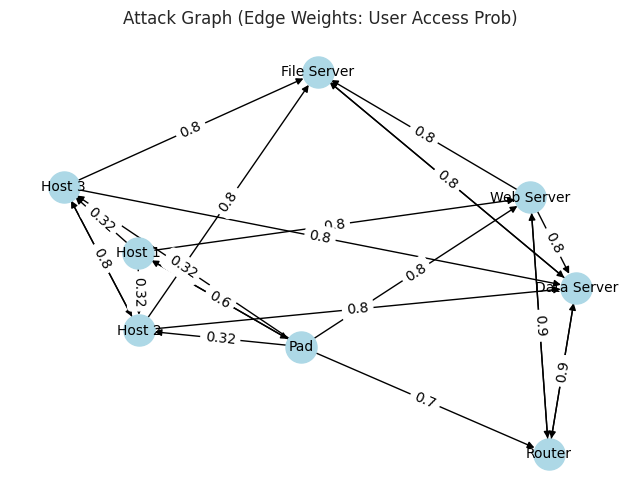

In [7]:
# --- EXPORT EMBEDDINGS ---
import os
x = 1
!mkdir graphs
path= './graphs/' + str(x)
while os.path.exists(path):
  x+=1
  path= './graphs/' + str(x)
!mkdir {path}
# Chuyển graphs sang numpy array
nodes_emb_np = final_node_embeddings.detach().numpy()
edges_emb_np = final_edge_embeddings.detach().numpy()

# 1. Tạo Figure và Axes
fig, ax = plt.subplots(figsize=(8, 6))

# 2. Vẽ biểu đồ lên Axes (ax)
pos = nx.spring_layout(G_original)
nx.draw(G_original, pos, ax=ax, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
edge_labels = nx.get_edge_attributes(G_original, 'user')
nx.draw_networkx_edge_labels(G_original, pos, ax=ax, edge_labels=edge_labels)
ax.set_title("Attack Graph (Edge Weights: User Access Prob)")

# 3. Bây giờ, biến 'fig' chính là thứ bạn muốn lưu
# Bạn có thể lưu nó ngay lập tức:
fig.savefig(path + "/attack_graph.png")

np.save(f'graphs/{x}/node_embeddings.npy', nodes_emb_np)
np.save(f'graphs/{x}/edge_embeddings.npy', edges_emb_np)
print("\n[THÀNH CÔNG] Đã lưu graphs vào 'node_embeddings.npy' và 'edge_embeddings.npy'")

In [8]:
# --- EXPORT GRAPH ---
import torch

# --- Lấy các biến tĩnh từ các cell trước ---
# G_original (từ cell 2)
# node_order (từ cell 3)
# node_features (features gốc, từ cell 3)
# edge_features (features gốc, từ cell 3)

# --- Tạo dictionary để lưu ---
static_data_to_save = {
    'G_original': G_original,
    'node_order': node_order,
    'node_map': {name: i for i, name in enumerate(node_order)},

    # Features gốc (đầu vào của GNN)
    'node_features_original': node_features,
    'edge_features_original': edge_features,
}

# --- Lưu vào một file duy nhất ---
STATIC_FILE_PATH = path + "/graph_environment.pth"
torch.save(static_data_to_save, STATIC_FILE_PATH)

print(f"[THÀNH CÔNG] Đã lưu dữ liệu môi trường tĩnh vào file: {STATIC_FILE_PATH}")

[THÀNH CÔNG] Đã lưu dữ liệu môi trường tĩnh vào file: ./graphs/2/graph_environment.pth


In [9]:
# --- LƯU TRỌNG SỐ CỦA MÔ HÌNH (STATE DICTIONARY) ---
MODEL_STATE_PATH = path + "/dgi_model_state_dict.pth"

# Lưu state_dict của mô hình DGI
torch.save(dgi_model.state_dict(), MODEL_STATE_PATH)

print(f"\n[THÀNH CÔNG] Đã lưu trọng số của mô hình vào file '{MODEL_STATE_PATH}'")


[THÀNH CÔNG] Đã lưu trọng số của mô hình vào file './graphs/2/dgi_model_state_dict.pth'


In [10]:
# --- EXPORT MODEL PARAMETERS ---

import torch

# --- Định nghĩa các tham số GNN ---
NDIM_IN = g_dgl.ndata['h'].shape[1]
EDIM = g_dgl.edata['h'].shape[1]
N_HIDDEN = 16
N_OUT = 24
N_LAYERS = 2
# (Các tham số khác như EPOCHS, LEARNING_RATE không cần thiết cho
# việc *khởi tạo* lại mô hình, nhưng bạn có thể thêm vào nếu muốn)

# --- Tạo dictionary chứa các tham số cần thiết cho việc tải mô hình ---
model_config = {
    'NDIM_IN': NDIM_IN,
    'EDIM': EDIM,
    'N_HIDDEN': N_HIDDEN,
    'N_OUT': N_OUT,
    'N_LAYERS': N_LAYERS
}

# --- Lưu dictionary vào file ---
CONFIG_FILE_PATH = path + "/model_config.pth"
torch.save(model_config, CONFIG_FILE_PATH)

print(f"[THÀNH CÔNG] Đã lưu cấu hình mô hình vào file: {CONFIG_FILE_PATH}")
print("Cấu hình đã lưu:", model_config)

[THÀNH CÔNG] Đã lưu cấu hình mô hình vào file: ./graphs/2/model_config.pth
Cấu hình đã lưu: {'NDIM_IN': 2, 'EDIM': 2, 'N_HIDDEN': 16, 'N_OUT': 24, 'N_LAYERS': 2}



--- Bảng Embedding cho các Nút (sau khi huấn luyện) ---
                emb_0     emb_1     emb_2     emb_3     emb_4     emb_5  \
Data Server -0.004637 -0.002530 -0.001671 -0.001781 -0.001727 -0.000662   
Pad         -0.003258 -0.001475 -0.001705 -0.001176 -0.000795 -0.001040   
Web Server  -0.001752 -0.001873 -0.000950 -0.000415 -0.000993 -0.000505   
Host 1      -0.001499 -0.002225 -0.000939 -0.001106 -0.001033 -0.000872   
Host 2      -0.001455 -0.001406 -0.000468 -0.000572 -0.000762 -0.000478   
Host 3      -0.001063 -0.001382 -0.000776 -0.000883 -0.000742 -0.000536   
File Server -0.001509 -0.000685 -0.001203 -0.000627 -0.000904 -0.001750   
Router      -0.002155 -0.002973 -0.001600 -0.001837 -0.001268 -0.000891   

                emb_6     emb_7     emb_8     emb_9    emb_10    emb_11  \
Data Server  0.018684 -0.002542  0.509898  0.046764  0.180367  0.103286   
Pad          0.080574 -0.004568  0.505122 -0.000499  0.074759  0.175569   
Web Server  -0.000810  0.148782  0.173313 

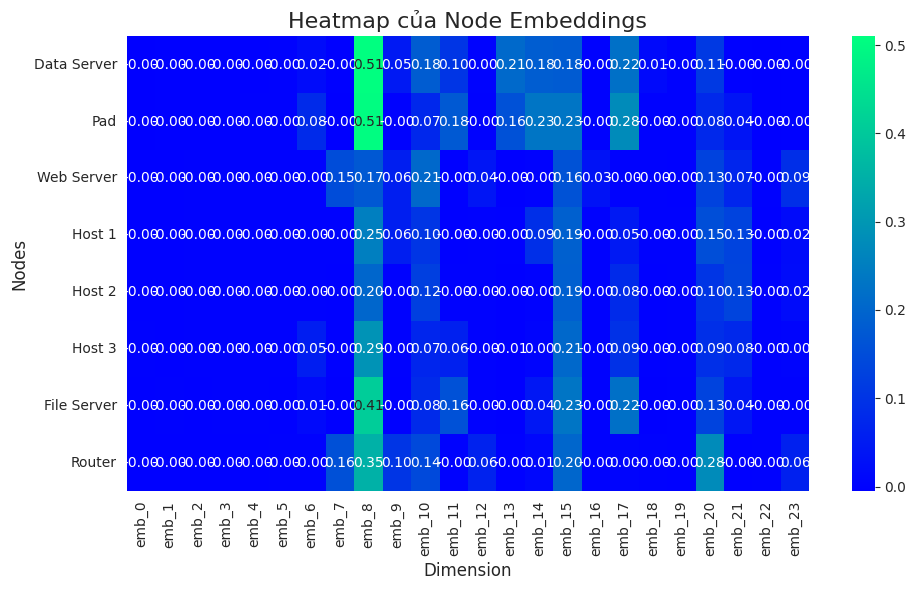

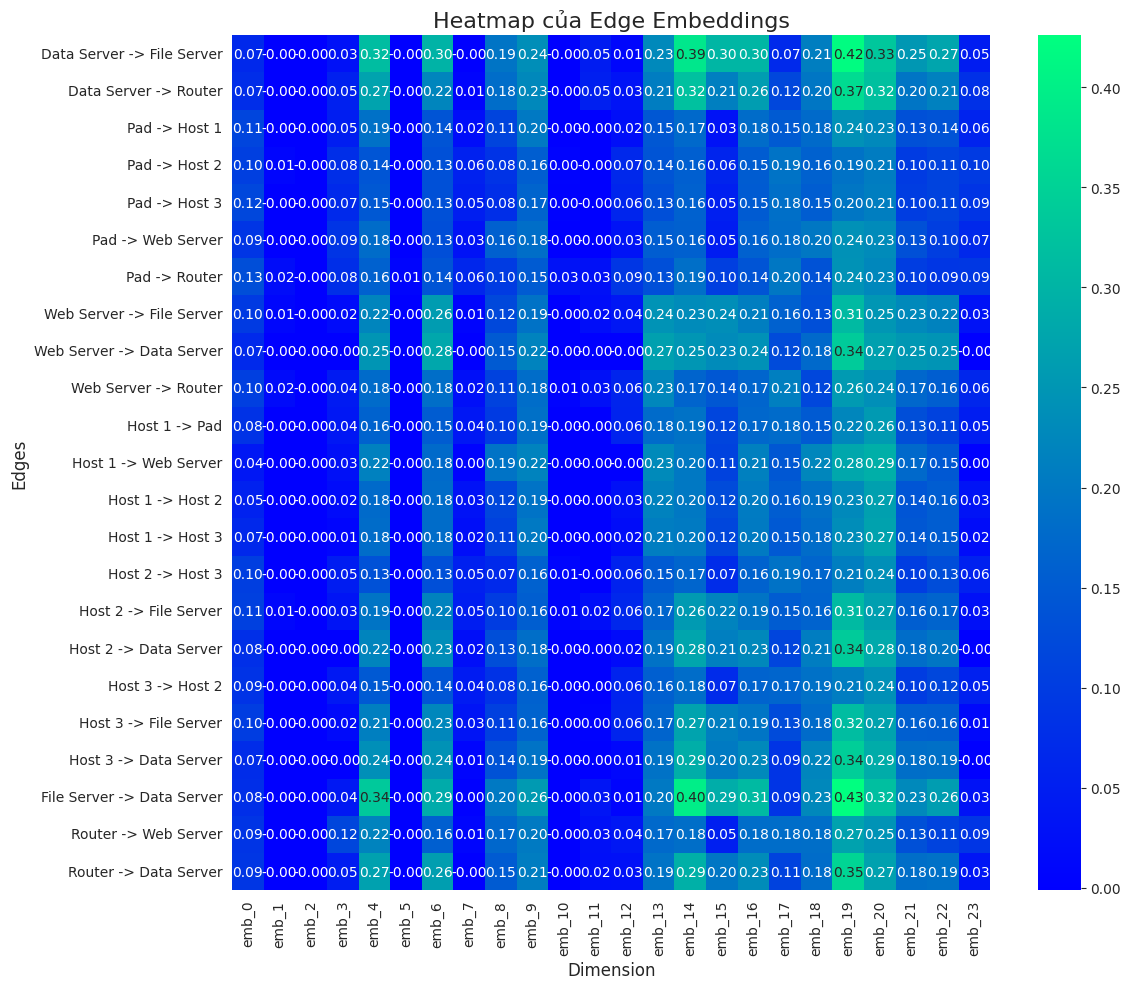

In [11]:
import pandas as pd
import seaborn as sns
# --- Lấy graphs cuối cùng từ bộ mã hóa đã được huấn luyện ---
dgi_model.eval() # Chuyển mô hình sang chế độ đánh giá
with torch.no_grad(): # Không tính toán gradient nữa
    final_node_embeddings, final_edge_embeddings = dgi_model.encoder(g_dgl, g_dgl.ndata['h'], g_dgl.edata['h'])

# Chuyển tensor sang numpy để xử lý
nodes_emb_np = final_node_embeddings.detach().numpy()
edges_emb_np = final_edge_embeddings.detach().numpy()

# --- Hiển thị dưới dạng bảng (Pandas) ---

print("\n--- Bảng Embedding cho các Nút (sau khi huấn luyện) ---")
# Tạo tên cho các cột embedding (ví dụ: emb_0, emb_1, ...)
node_emb_cols = [f'emb_{i}' for i in range(nodes_emb_np.shape[1])]
# Tạo DataFrame
df_nodes = pd.DataFrame(nodes_emb_np, index=node_order, columns=node_emb_cols)
pd.set_option('display.max_columns', None)
print(df_nodes)


print("\n--- Bảng Embedding cho các Cạnh (sau khi huấn luyện) ---")
# Tạo một DataFrame mới cho các cạnh với thông tin nút nguồn và nút đích
original_edges_list = list(G_original.edges())
edge_data = {
    'Source': [u for u, v in original_edges_list],
    'Destination': [v for u, v in original_edges_list]
}
edge_emb_cols = [f'emb_{i}' for i in range(edges_emb_np.shape[1])]
df_edges = pd.DataFrame(edge_data)
df_edges_emb = pd.DataFrame(edges_emb_np, columns=edge_emb_cols)
df_edges_final = pd.concat([df_edges, df_edges_emb], axis=1)
print(df_edges_final)


# --- Trực quan hóa bằng Heatmap (Seaborn) ---
try:
    plt.rcParams['font.family'] = 'sans-serif'

    # Heatmap cho Node Embeddings
    plt.figure(figsize=(10, 6)) # Tùy chỉnh kích thước hình
    sns.heatmap(df_nodes, annot=True, cmap='winter', fmt='.2f')
    plt.title('Heatmap của Node Embeddings', fontsize=16)
    plt.xlabel('Dimension', fontsize=12)
    plt.ylabel('Nodes', fontsize=12)
    plt.tight_layout()
    print("\n[THÀNH CÔNG] Đã lưu heatmap của node graphs vào file 'node_embeddings_heatmap.png'")

    # Heatmap cho Edge Embeddings
    # Tạo nhãn cho trục y của heatmap cạnh
    edge_labels = [f'{u} -> {v}' for u, v in original_edges_list]
    plt.figure(figsize=(12, 10)) # Tùy chỉnh kích thước hình
    sns.heatmap(df_edges_emb, yticklabels=edge_labels, annot=True, cmap='winter', fmt='.2f')
    plt.title('Heatmap của Edge Embeddings', fontsize=16)
    plt.xlabel('Dimension', fontsize=12)
    plt.ylabel('Edges', fontsize=12)
    plt.tight_layout()
    print("[THÀNH CÔNG] Đã lưu heatmap của edge graphs vào file 'edge_embeddings_heatmap.png'")

except Exception as e:
    print(f"\n[LỖI] Không thể tạo heatmap. Vui lòng đảm bảo bạn đã cài đặt matplotlib và seaborn.")
    print(f"Lỗi chi tiết: {e}")

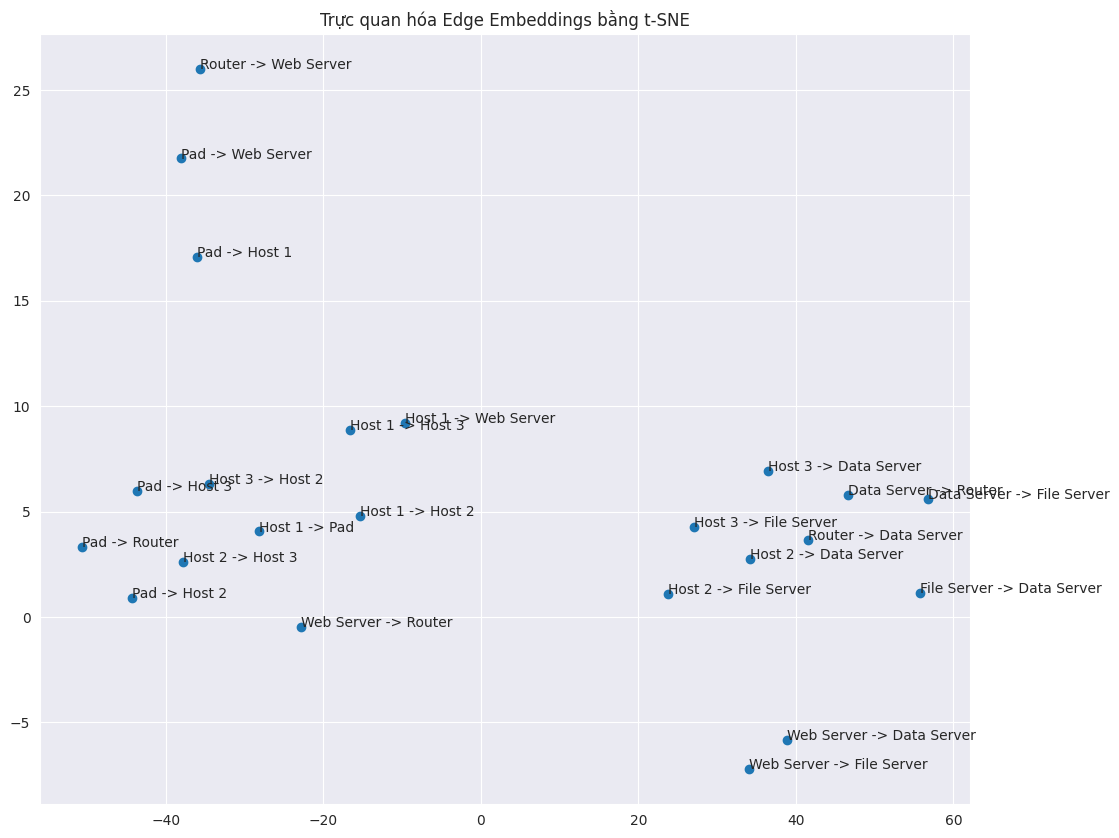

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE

# Chuyển graphs cạnh sang numpy array
edge_embeddings_np = final_edge_embeddings.detach().numpy()
edge_labels = [f'{u} -> {v}' for u, v in G_original.edges()]

# Sử dụng t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(edge_labels)-1))
embeddings_2d = tsne.fit_transform(edge_embeddings_np)

# Vẽ biểu đồ
plt.figure(figsize=(12, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# Thêm nhãn
for i, label in enumerate(edge_labels):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]))

plt.title('Trực quan hóa Edge Embeddings bằng t-SNE')
plt.show()

In [13]:
# Lấy node graphs và bản đồ node
node_embeddings_np = final_node_embeddings.detach().numpy()
node_map = {name: i for i, name in enumerate(node_order)}

# Tạo lại danh sách các cạnh không tồn tại (mẫu âm)
np.random.seed(42) # Đặt seed để kết quả có thể tái tạo
positive_edges = list(G_original.edges())
num_positive = len(positive_edges)
negative_edges = []
all_nodes = list(G_original.nodes())
while len(negative_edges) < num_positive:
    u, v = np.random.choice(all_nodes, 2, replace=False)
    if not G_original.has_edge(u, v) and (u, v) not in negative_edges:
        negative_edges.append((u, v))

# Tạo đặc trưng cho các cạnh không tồn tại
negative_edge_features = []
for u, v in negative_edges:
    u_emb = node_embeddings_np[node_map[u]]
    v_emb = node_embeddings_np[node_map[v]]
    edge_feature = u_emb * v_emb # Phép nhân Hadamard
    negative_edge_features.append(edge_feature)
X_negative = np.array(negative_edge_features)

# Hiển thị dưới dạng bảng
print("\n--- Bảng Embedding cho các Cạnh KHÔNG Tồn Tại (Mẫu Âm) ---")
edge_labels = [f'{u} -> {v}' for u, v in negative_edges]
edge_emb_cols = [f'emb_{i}' for i in range(X_negative.shape[1])]
df_negative_edges = pd.DataFrame(X_negative, index=edge_labels, columns=edge_emb_cols)
pd.set_option('display.max_columns', None) # Đảm bảo in ra tất cả các cột
print(df_negative_edges)


--- Bảng Embedding cho các Cạnh KHÔNG Tồn Tại (Mẫu Âm) ---
                              emb_0     emb_1         emb_2         emb_3  \
Host 1 -> Router           0.000003  0.000007  1.502169e-06  2.031640e-06   
Host 3 -> Web Server       0.000002  0.000003  7.374962e-07  3.665289e-07   
Pad -> File Server         0.000005  0.000001  2.051161e-06  7.365659e-07   
Host 2 -> Web Server       0.000003  0.000003  4.447924e-07  2.371175e-07   
File Server -> Host 1      0.000002  0.000002  1.129763e-06  6.928213e-07   
Host 3 -> Router           0.000002  0.000004  1.242026e-06  1.623331e-06   
Data Server -> Web Server  0.000008  0.000005  1.587668e-06  7.389560e-07   
Web Server -> Pad          0.000006  0.000003  1.619423e-06  4.876837e-07   
Web Server -> Host 2       0.000003  0.000003  4.447924e-07  2.371175e-07   
Host 1 -> Data Server      0.000007  0.000006  1.569541e-06  1.969491e-06   
Host 1 -> File Server      0.000002  0.000002  1.129763e-06  6.928213e-07   
Host 3 -> Host 1

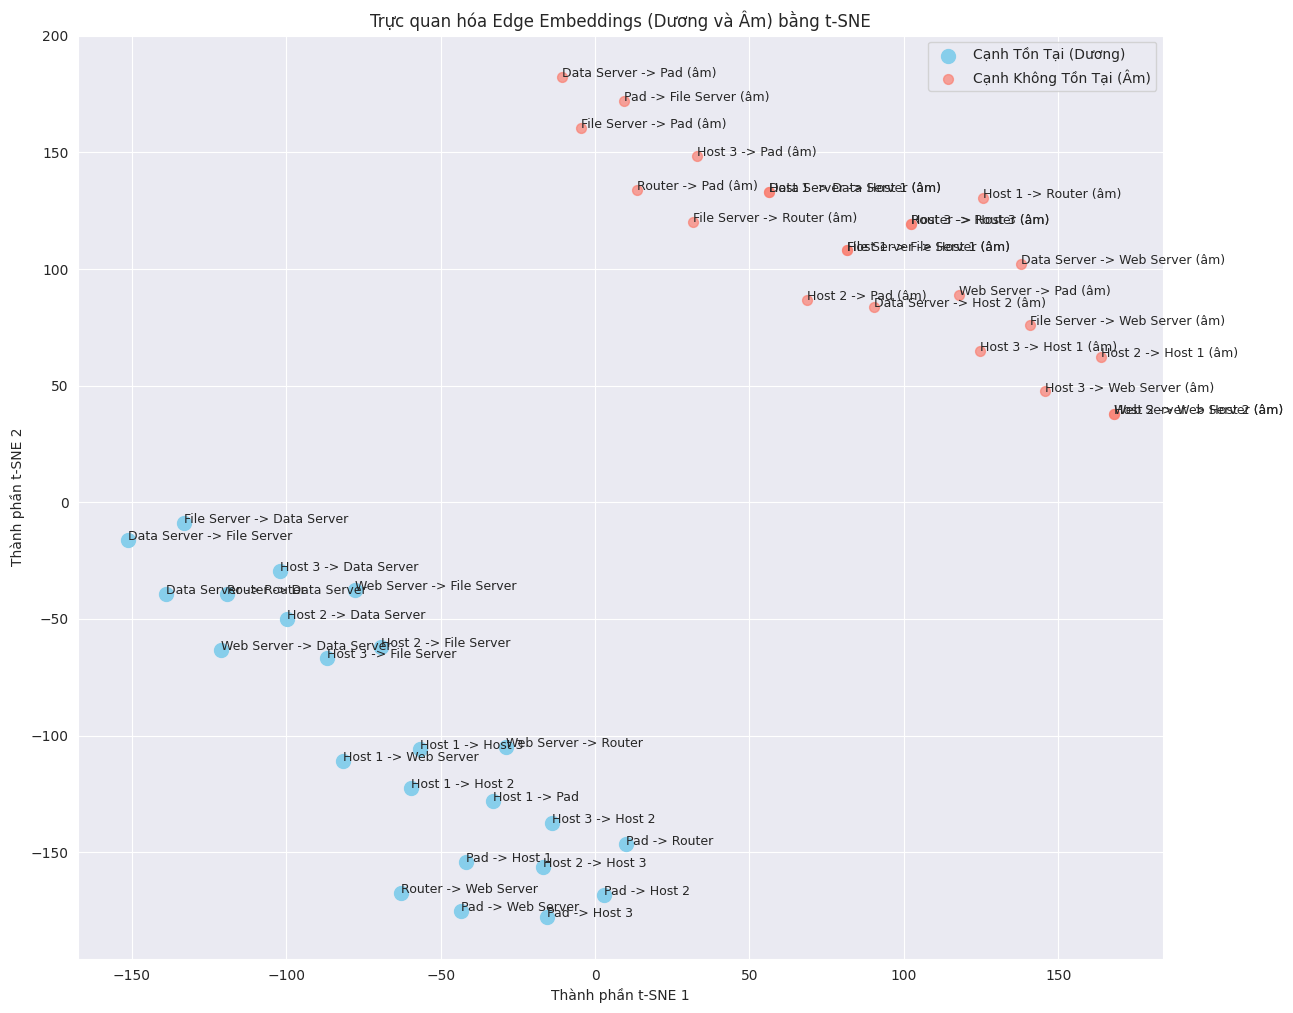

In [14]:
# Chuẩn bị dữ liệu embedding cho cả hai loại cạnh ---

# Lấy embedding của các cạnh có thật (mẫu dương)
positive_embeddings_np = final_edge_embeddings.detach().numpy()
positive_edges = list(G_original.edges())
positive_labels = [f'{u} -> {v}' for u, v in positive_edges]
num_positive = len(positive_edges)

# Tạo và tính embedding cho các cạnh không tồn tại (mẫu âm)
np.random.seed(42) # Đặt seed để kết quả có thể tái tạo
node_embeddings_np = final_node_embeddings.detach().numpy()
node_map = {name: i for i, name in enumerate(node_order)}

negative_edges = []
all_nodes = list(G_original.nodes())
while len(negative_edges) < num_positive:
    u, v = np.random.choice(all_nodes, 2, replace=False)
    if not G_original.has_edge(u, v) and (u, v) not in negative_edges:
        negative_edges.append((u, v))

negative_edge_features = []
for u, v in negative_edges:
    u_emb = node_embeddings_np[node_map[u]]
    v_emb = node_embeddings_np[node_map[v]]
    edge_feature = u_emb * v_emb
    negative_edge_features.append(edge_feature)
negative_embeddings_np = np.array(negative_edge_features)
negative_labels = [f'{u} -> {v} (âm)' for u, v in negative_edges]


# Kết hợp tất cả embedding và chạy t-SNE ---

# Kết hợp embedding dương và âm
all_embeddings_np = np.vstack([positive_embeddings_np, negative_embeddings_np])
all_labels = positive_labels + negative_labels

# Chạy t-SNE trên toàn bộ dữ liệu
tsne = TSNE(n_components=2, random_state=42, perplexity=min(10, len(all_labels)-1))
embeddings_2d = tsne.fit_transform(all_embeddings_np)


# Vẽ biểu đồ với màu sắc khác nhau ---

plt.figure(figsize=(14, 12))

# Vẽ các điểm của cạnh có thật (màu xanh)
plt.scatter(embeddings_2d[:num_positive, 0], embeddings_2d[:num_positive, 1],
            c='skyblue', label='Cạnh Tồn Tại (Dương)', s=100)

# Vẽ các điểm của cạnh không tồn tại (màu đỏ)
plt.scatter(embeddings_2d[num_positive:, 0], embeddings_2d[num_positive:, 1],
            c='salmon', label='Cạnh Không Tồn Tại (Âm)', s=50, alpha=0.7)

# Thêm nhãn cho từng điểm
for i, label in enumerate(all_labels):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

plt.title('Trực quan hóa Edge Embeddings (Dương và Âm) bằng t-SNE')
plt.xlabel('Thành phần t-SNE 1')
plt.ylabel('Thành phần t-SNE 2')
plt.legend()
plt.grid(True)
plt.show()


--- Trực quan hóa Node Embeddings bằng t-SNE (theo Priority) ---


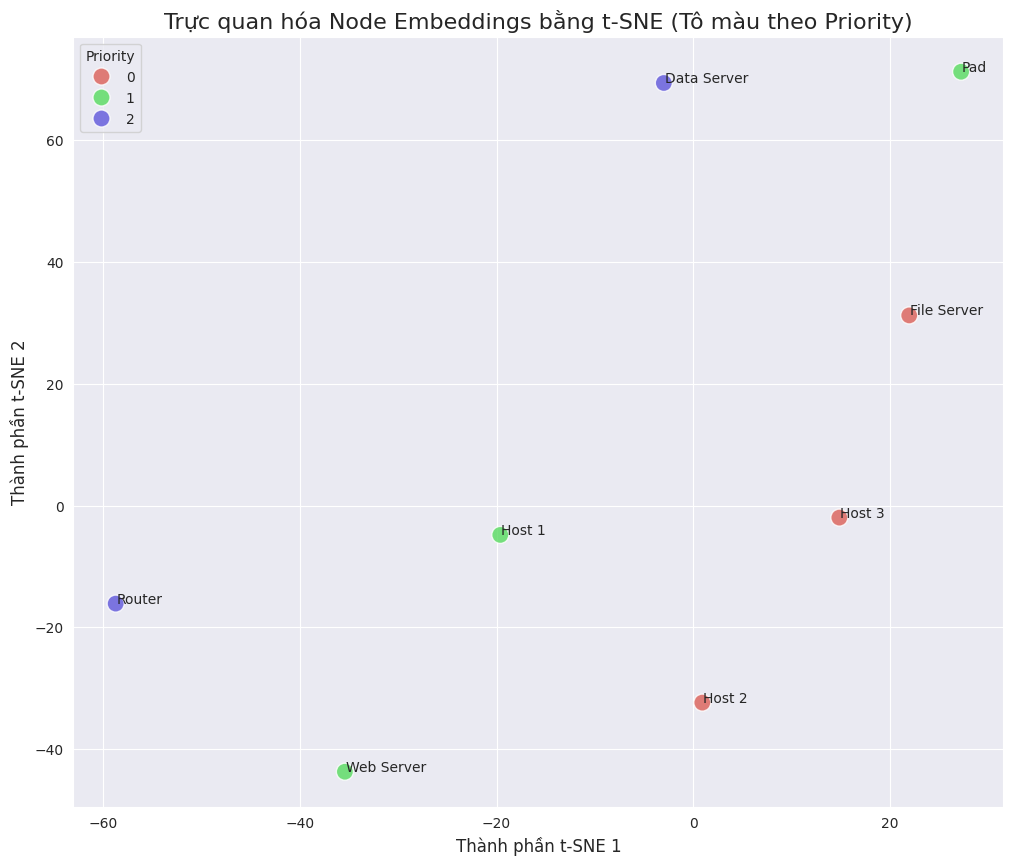

In [15]:
print("\n--- Trực quan hóa Node Embeddings bằng t-SNE (theo Priority) ---")

# Chuyển graphs sang numpy array
embeddings_np = final_node_embeddings.detach().numpy()

# Sử dụng t-SNE để giảm chiều dữ liệu xuống 2 chiều
tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(node_order)-1))
embeddings_2d = tsne.fit_transform(embeddings_np)

# Tạo DataFrame để dễ dàng vẽ biểu đồ
df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
df['node_name'] = node_order
df['priority'] = [node_attributes[name]['priority'] for name in node_order]

# Vẽ biểu đồ
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=df,
    x='x',
    y='y',
    hue='priority',
    palette=sns.color_palette("hls", n_colors=df['priority'].nunique()),
    s=150, # Kích thước điểm
    alpha=0.8
)

# Thêm nhãn cho từng điểm
for i, row in df.iterrows():
    plt.text(row.x + 0.1, row.y + 0.1, row.node_name, fontsize=10)

plt.title('Trực quan hóa Node Embeddings bằng t-SNE (Tô màu theo Priority)', fontsize=16)
plt.xlabel('Thành phần t-SNE 1', fontsize=12)
plt.ylabel('Thành phần t-SNE 2', fontsize=12)
plt.legend(title='Priority')
plt.grid(True)
plt.show()



--- Biểu diễn Ma trận Khoảng cách dưới dạng Heatmap ---

[THÀNH CÔNG] Đã lưu heatmap của ma trận khoảng cách vào file 'node_distance_heatmap.png'


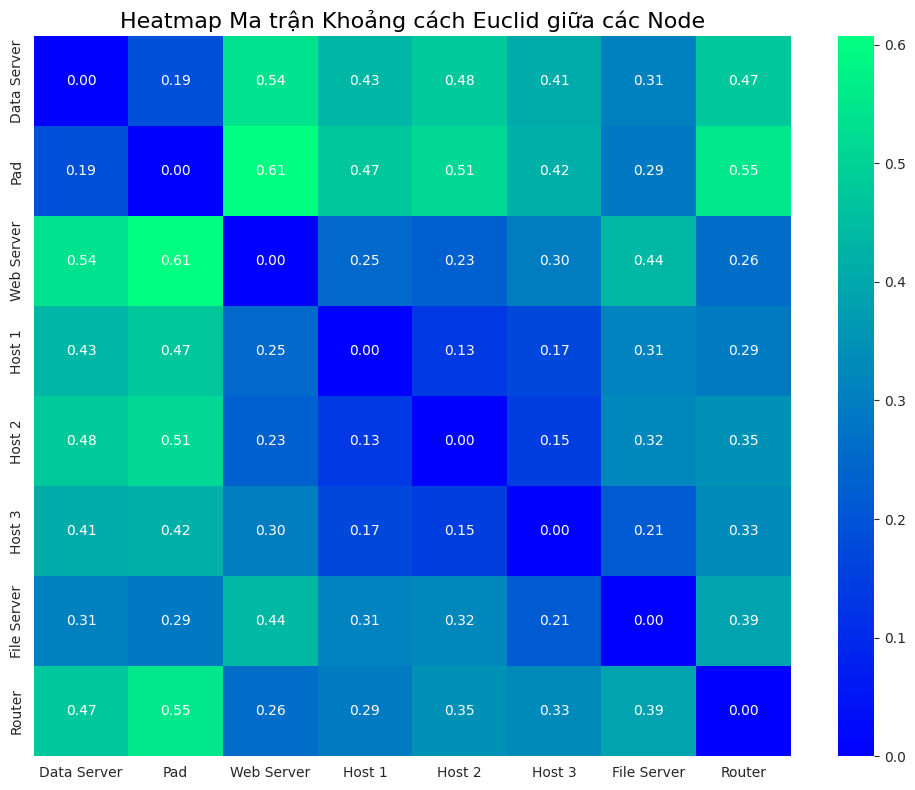

In [16]:
from scipy.spatial.distance import pdist, squareform

print("\n--- Biểu diễn Ma trận Khoảng cách dưới dạng Heatmap ---")
plt.rcParams['text.color'] = 'black'
# Chuyển graphs sang numpy array
embeddings_np = final_node_embeddings.detach().numpy()

# Tính toán ma trận khoảng cách
distance_condensed = pdist(embeddings_np, metric='euclidean')
distance_matrix = squareform(distance_condensed)

# Tạo DataFrame để có nhãn cho biểu đồ
df_distance = pd.DataFrame(distance_matrix, index=node_order, columns=node_order)

# Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    df_distance,
    annot=True,        # Hiển thị giá trị số trên ô
    annot_kws={"color": "white"},
    cmap="winter",  # Chọn bảng màu (viridis_r: màu đậm cho giá trị thấp)
    fmt=".2f"          # Định dạng số hiển thị (2 chữ số sau dấu phẩy)
)

plt.title('Heatmap Ma trận Khoảng cách Euclid giữa các Node', fontsize=16)
plt.tight_layout() # Tự động điều chỉnh cho vừa vặn
print("\n[THÀNH CÔNG] Đã lưu heatmap của ma trận khoảng cách vào file 'node_distance_heatmap.png'")
plt.show()

In [17]:
# # --- ORIGINAL GRAPH ---
# # --- Step 1: Create directed attack graph ---
# G_original = nx.DiGraph()
# G_original.add_nodes_from(["Data Server", "Pad", "Web Server", "Host 1", "Host 2", "Host 3", "File Server"
#                               # , "New Node"
#                            ])
#
# # --- Step 2: Add node attributes (priority + state) ---
# node_attributes = {
#     "Data Server": {"state": 0, "priority": 2},
#     "Pad": {"state": 0, "priority": 1},
#     "Web Server": {"state": 0, "priority": 1},
#     "Host 1": {"state": 0, "priority": 1},
#     "Host 2": {"state": 0, "priority": 0},
#     "Host 3": {"state": 0, "priority": 0},
#     "File Server": {"state": 0, "priority": 0},
#     # "New Node": {"state": 0, "priority": 0}
# }
# nx.set_node_attributes(G_original, node_attributes)
#
# # --- Step 3: Add edges with weights (user/root access probabilities) ---
# edges = [
#     ("Pad", "Host 1", {"user": 0.6, "root": 0.48}),
#     ("Pad", "Host 2", {"user": 0.32, "root": 0.32}),
#     ("Pad", "Host 3", {"user": 0.32, "root": 0.32}),
#     ("Pad", "Web Server", {"user": 0.8, "root": 0.6}),
#     ("Host 1", "Pad", {"user": 0.6, "root": 0.6}),
#     ("Host 1", "Web Server", {"user": 0.8, "root": 0.6}),
#     ("Host 1", "Host 2", {"user": 0.32, "root": 0.32}),
#     ("Host 1", "Host 3", {"user": 0.32, "root": 0.32}),
#     ("Host 2", "Host 3", {"user": 0.8, "root": 0.8}),
#     ("Host 2", "File Server", {"user": 0.8, "root": 0.6}),
#     ("Host 2", "Data Server", {"user": 0.8, "root": 0.6}),
#     ("Host 3", "Host 2", {"user": 0.8, "root": 0.8}),
#     ("Host 3", "File Server", {"user": 0.8, "root": 0.6}),
#     ("Host 3", "Data Server", {"user": 0.8, "root": 0.6}),
#     ("Web Server", "File Server", {"user": 0.8, "root": 0.04}),
#     ("Web Server", "Data Server", {"user": 0.8, "root": 0.04}),
#     ("File Server", "Data Server", {"user": 0.8, "root": 0.04}),
#     # ("Data Server", "New Node", {"user": 0.8, "root": 0.04})
# ]